In [1]:
import os
os.chdir('..')

import numpy as np
import json
import torch

from systems import SpatialSIR3D
from lightning_module import PreTrainLightningSpatial
from models import MaskedAutoencoderViT3D

from inference_utils import load_pretrained_model, labels2map

In [2]:
observational_data = np.load('/home/jp4474/viaABC/data/SPATIAL/data.npy')

In [3]:
observational_data = np.expand_dims(labels2map(observational_data), axis=0).transpose(0, 2, 1, 3, 4)

In [4]:
observational_data.shape

(1, 3, 15, 80, 80)

In [5]:
model = load_pretrained_model(
    model_class=MaskedAutoencoderViT3D,
    lightning_class=PreTrainLightningSpatial,
    checkpoint_substr="SpatialSIR",
    folder_name='/home/jp4474/viaABC/Sirs/spatialSIR3D_d128_ed64_6_8_4_8_vae_mask_0.15_beta_0.01',)

img_size (80, 80) patch_size (8, 8) frames 15 t_patch_size 3
model initialized
Successfully loaded model


In [6]:
with torch.no_grad():
    _, pred, _ = model(torch.tensor(observational_data, dtype=torch.float32).to(model.device), mask_ratio=0.0)

In [21]:
abc.get_latent(torch.tensor(observational_data, dtype=torch.float32).to(model.device)).shape

(1, 500, 64)

In [7]:
pred.shape

torch.Size([1, 500, 576])

In [8]:
# unpatchify the prediction
pred = model.model.unpatchify(pred)

In [9]:
pred_np = pred.cpu().numpy().squeeze(0)

In [10]:
pred_np.shape

(3, 15, 80, 80)

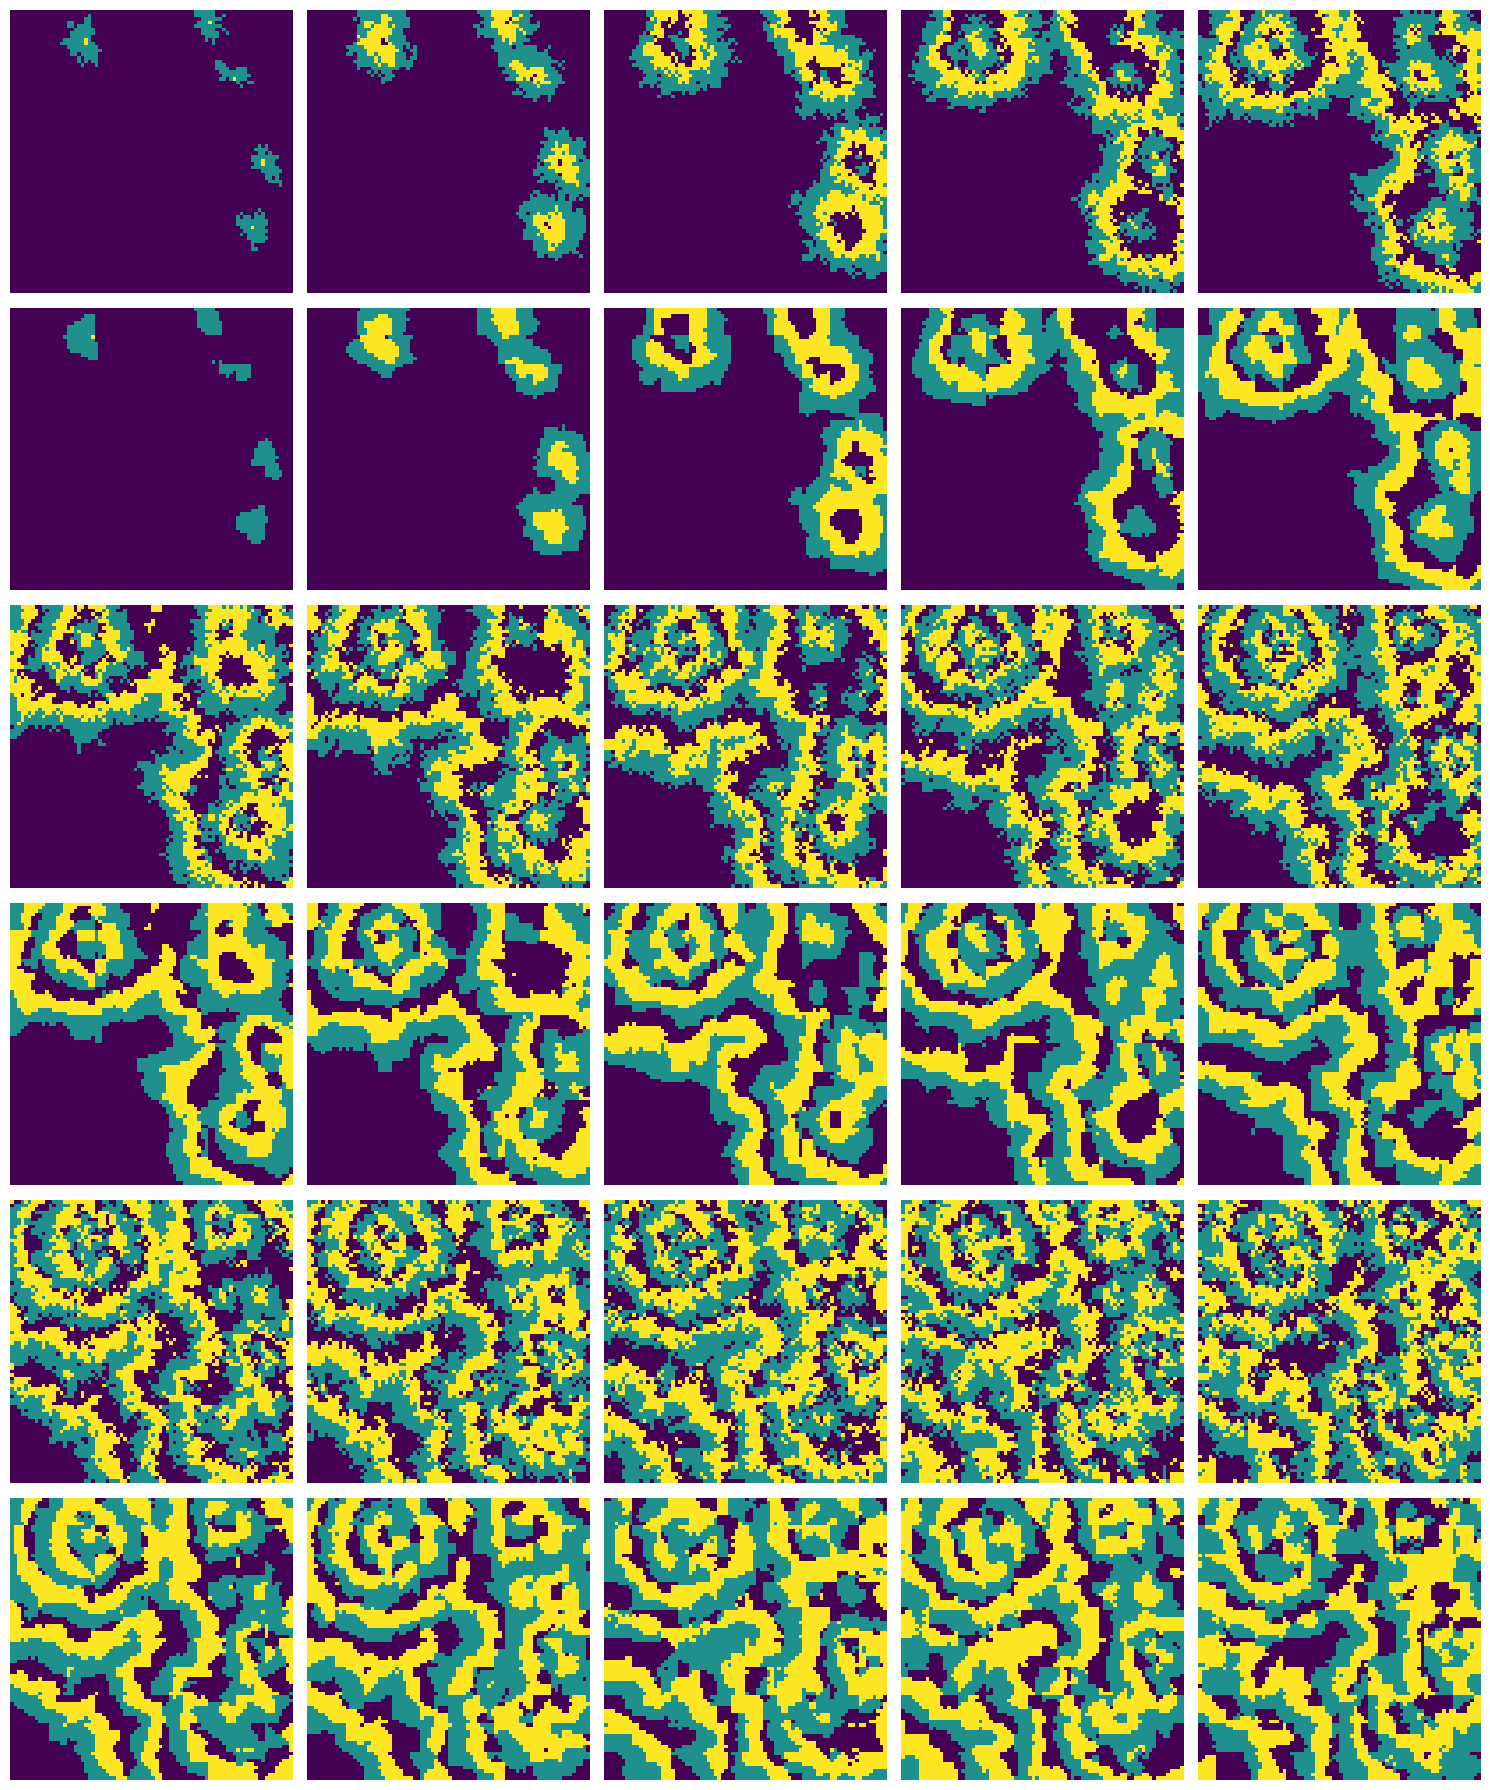

In [11]:
import matplotlib.pyplot as plt

# Enhanced comparison plot with 6x5 grid (30 slices total: 15 obs + 15 inf)
fig, ax = plt.subplots(6, 5, figsize=(15, 18))

# Convert inferred_data back to class labels for comparison
inferred_labels = np.argmax(pred_np, axis=0)  # Convert from one-hot to class labels
obs_labels = np.argmax(observational_data.squeeze(0), axis=0)  # Convert from one-hot to class labels

# Organize by rows: 
# Row 0: obs 0-4, Row 1: inf 0-4, Row 2: obs 5-9, Row 3: inf 5-9, Row 4: obs 10-14, Row 5: inf 10-14
for row in range(6):
    for col in range(5):
        # Calculate which time block we're in (0-4, 5-9, or 10-14)
        time_block = row // 2  # 0, 1, or 2
        time_idx = time_block * 5 + col  # time index within the 15 time points
        
        if time_idx < 15:  # Make sure we don't exceed our data
            if row % 2 == 0:  # Even rows (0, 2, 4) - Observed data
                im = ax[row, col].imshow(obs_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
            else:  # Odd rows (1, 3, 5) - Inferred data
                im = ax[row, col].imshow(inferred_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
        
        ax[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.0)  # Make room for row labels and add horizontal spacing
plt.show()

In [14]:
from cuml.manifold.umap import UMAP

In [16]:
abc = SpatialSIR3D(model=model, pooling_method='cls')

INFO:viaABC:Initializing viaABC class
INFO:viaABC:Model updated


NotImplementedError: Pooling method 'cls' is not implemented for 3D ViT

In [ ]:
abc.get_latent()

In [ ]:
data = generate_data()
 
# running default. Runs with NN Descent if data has more than 50K points
umap = UMAP(n_neighbors=16)
emb  = umap.fit_transform(data)
 
# explicitly set build algo. Runs with this regardless of the data size. Data can be put on host
umap = UMAP(n_neighbors=16, build_algo="nn_descent", build_kwds={"nnd_graph_degree": 32})
emb = umap.fit_transform(data, data_on_host=True)
 
# batching NN Descent with 4 clusters
umap = UMAP(n_neighbors=16, build_algo="nn_descent", build_kwds={"nnd_do_batch": True, "nnd_n_clusters": 4})
emb = umap.fit_transform(data, data_on_host=True)